# Regional and Socioeconomic Subgroup Evaluation: FFNN with Class Weights

Best-performing model (FFNN with Class Weights) across geographic and socio-economic subgroups.

In [1]:
import numpy as np
import pandas as pd
import gc
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (classification_report, accuracy_score, f1_score, 
                             recall_score, precision_score, confusion_matrix)
from sklearn.utils.class_weight import compute_class_weight

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Import project preprocessing pipeline
from src.preprocessing_pipeline import build_preprocessed_data

# Configuration
RANDOM_STATE = 207
np.random.seed(RANDOM_STATE)

# Class labels
CLASS_NAMES = ['small', 'medium', 'large', 'very large']

# Presentation style (dark theme more aligned with Berkeley pallet)
plt.rcParams.update({
    'figure.facecolor': '#1a1a2e',
    'axes.facecolor': '#16213e',
    'axes.edgecolor': '#e94560',
    'axes.labelcolor': 'white',
    'text.color': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'grid.color': '#0f3460',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'figure.dpi': 150
})

# Color palettes for visualizations
REGION_COLORS = {
    'lat': ['#e94560', '#ff6b6b', '#feca57', '#48dbfb', '#1dd1a1'],
    'lon': ['#5f27cd', '#341f97', '#00d2d3', '#54a0ff', '#ff9f43', '#ee5253']
}

CLASS_COLORS = ['#00d2d3', '#54a0ff', '#ff9f43', '#ee5253']

print("Libraries loaded successfully.")

2025-12-13 09:50:44.276835: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-13 09:50:44.486038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-13 09:50:44.486103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-13 09:50:44.515740: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-13 09:50:44.586757: I tensorflow/core/platform/cpu_feature_guar

Libraries loaded successfully.


## Step 1: Load Preprocessed Data via Pipeline

Using `build_preprocessed_data()` with class weights strategy (no SMOTE) for this analysis.

In [2]:
print("Loading preprocessed data using the pipeline...")

# Build preprocessed data for class weights (no SMOTE)
data = build_preprocessed_data(
    use_smote=False,
    impute_strategy='subgroup_mean',
    output_format='standard',
    n_per_class=1000  # Balanced sampling,
)

# Extract standardized features and labels
X_train = data['X_train_std']
X_val = data['X_val_std']
X_test = data['X_test_std']

y_train = data['Y_train']
y_val = data['Y_val']
y_test = data['Y_test']

# Get processed DataFrames
df_train_proc = data['df_train_processed']
df_val_proc = data['df_val_processed']
df_test_proc = data['df_test_processed']

print(f"\nTraining shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

print(f"\nClass distribution (training):")
for i, name in enumerate(CLASS_NAMES):
    print(f"  {name}: {(y_train == i).sum()}")

Loading preprocessed data using the pipeline...
[Memory] Pipeline start: 0.66 GB
Loading the file using Polars...
File loaded successfully with Polars. Shape: (2302521, 308)
Converted the Polars DataFrame to Pandas.
[Memory] After data load: 28.25 GB
Loaded 2302521 rows
[Memory] After sampling: 24.00 GB
Imputing with subgroup mean (GACC_PL)...
[Memory] Pipeline complete: 22.07 GB

Training shape: (2400, 52)
Validation shape: (800, 52)
Test shape: (800, 52)

Class distribution (training):
  small: 606
  medium: 591
  large: 595
  very large: 608


## Step 2: Extract Regional Metadata from Processed Data

The preprocessing pipeline includes LATITUDE and LONGITUDE in `_select_features()`, so we can extract them directly.

In [3]:
# Check available columns in processed dataframes
print("Columns in processed data:")
print(list(df_train_proc.columns)[:15], "...")

# Extract coordinates
lat_train = df_train_proc['LATITUDE'].values
lon_train = df_train_proc['LONGITUDE'].values
lat_val = df_val_proc['LATITUDE'].values
lon_val = df_val_proc['LONGITUDE'].values
lat_test = df_test_proc['LATITUDE'].values
lon_test = df_test_proc['LONGITUDE'].values

Columns in processed data:
['FIRE_SIZE_LABEL', 'FIRE_YEAR', 'DISCOVERY_DOY', 'LATITUDE', 'LONGITUDE', 'pr_5D_mean', 'tmmn_5D_mean', 'tmmx_5D_mean', 'rmin_5D_mean', 'rmax_5D_mean', 'sph_5D_mean', 'vs_5D_mean', 'th_5D_mean', 'srad_5D_mean', 'etr_5D_mean'] ...


In [4]:
def assign_lat_region(lat):
    """Latitude region based on degrees."""
    if pd.isna(lat):
        return 'Unknown'
    elif lat < 30:
        return 'South (18-30°)'
    elif lat < 37:
        return 'Gulf States (30-37°)'
    elif lat < 42:
        return 'Central (37-42°)'
    elif lat < 49:
        return 'North-Central (42-49°)'
    else:
        return 'North (49-72°)'

def assign_lon_region(lon):
    """Longitude region based on degrees."""
    if pd.isna(lon):
        return 'Unknown'
    elif lon < -115:
        return 'Pacific Coast'
    elif lon < -105:
        return 'Mountain West'
    elif lon < -95:
        return 'Great Plains'
    elif lon < -85:
        return 'Midwest'
    elif lon < -75:
        return 'Southeast'
    else:
        return 'Atlantic'

def assign_mtbs_region(lon):
    """Categorize by MTBS threshold region (West vs East at -100°)."""
    if pd.isna(lon):
        return 'Unknown'
    return 'Western US' if lon < -100 else 'Eastern US'

# Create region assignments for all splits
lat_regions_train = pd.Series(lat_train).apply(assign_lat_region)
lat_regions_val = pd.Series(lat_val).apply(assign_lat_region)
lat_regions_test = pd.Series(lat_test).apply(assign_lat_region)

lon_regions_train = pd.Series(lon_train).apply(assign_lon_region)
lon_regions_val = pd.Series(lon_val).apply(assign_lon_region)
lon_regions_test = pd.Series(lon_test).apply(assign_lon_region)

mtbs_regions_test = pd.Series(lon_test).apply(assign_mtbs_region)

## Step 3: Train FFNN with Class Weights

In [5]:
# Compute class weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

print("Class Weights:")
for cls, w in class_weights.items():
    print(f"  {CLASS_NAMES[cls]}: {w:.4f}")

Class Weights:
  small: 0.9901
  medium: 1.0152
  large: 1.0084
  very large: 0.9868


In [6]:
def build_ffnn(input_dim, num_classes):
    """Build the Feed-Forward Neural Network (same architecture as notebook 04)."""
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Convert to float32
X_train_f32 = X_train.astype('float32')
X_val_f32 = X_val.astype('float32')
X_test_f32 = X_test.astype('float32')

# Build model
num_classes = 4
model = build_ffnn(X_train_f32.shape[1], num_classes)
model.summary()

2025-12-13 09:51:05.747672: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-13 09:51:05.855606: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-13 09:51:05.855663: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-13 09:51:05.857312: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-13 09:51:05.857358: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3392      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 5604 (21.89 KB)
Trainable params: 5604 (21.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-13 09:51:05.960141: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9511 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [7]:
# Training
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True,
    verbose=1
)

print("Training FFNN with Class Weights...")
history = model.fit(
    X_train_f32, y_train.astype('int32'),
    epochs=50,
    batch_size=32,
    validation_data=(X_val_f32, y_val.astype('int32')),
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

Training FFNN with Class Weights...
Epoch 1/50


2025-12-13 09:51:07.401663: I external/local_xla/xla/service/service.cc:168] XLA service 0x7daa3214cd00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-13 09:51:07.401692: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-12-13 09:51:07.415574: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-13 09:51:07.442401: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1765637467.498472   97116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 [==============================] - 2s 5ms/step - loss: 1.3352 - accuracy: 0.3650 - val_loss: 1.1787 - val_accuracy: 0.4462
Epoch 2/50
75/75 [==============================] - 0s 3ms/step - loss: 1.1960 - accuracy: 0.4358 - val_loss: 1.1317 - val_accuracy: 0.4725
Epoch 3/50
75/75 [==============================] - 0s 4ms/step - loss: 1.1560 - accuracy: 0.4512 - val_loss: 1.1020 - val_accuracy: 0.4737
Epoch 4/50
75/75 [==============================] - 0s 3ms/step - loss: 1.1159 - accuracy: 0.4758 - val_loss: 1.0836 - val_accuracy: 0.4900
Epoch 5/50
75/75 [==============================] - 0s 3ms/step - loss: 1.0915 - accuracy: 0.4883 - val_loss: 1.0675 - val_accuracy: 0.5063
Epoch 6/50
75/75 [==============================] - 0s 3ms/step - loss: 1.0815 - accuracy: 0.4892 - val_loss: 1.0606 - val_accuracy: 0.5088
Epoch 7/50
75/75 [==============================] - 0s 4ms/step - loss: 1.0646 - accuracy: 0.5000 - val_loss: 1.0517 - val_accuracy: 0.5050
Epoch 8/50
75/75 [=============

In [8]:
# Generate predictions
y_pred_val = np.argmax(model.predict(X_val_f32, verbose=0), axis=1)
y_pred_test = np.argmax(model.predict(X_test_f32, verbose=0), axis=1)

print("OVERALL MODEL PERFORMANCE")
print(f"\nValidation Accuracy: {accuracy_score(y_val, y_pred_val):.4f}")
print(f"Validation Macro F1: {f1_score(y_val, y_pred_val, average='macro'):.4f}")
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Test Macro F1: {f1_score(y_test, y_pred_test, average='macro'):.4f}")

print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test, target_names=CLASS_NAMES))

OVERALL MODEL PERFORMANCE

Validation Accuracy: 0.5138
Validation Macro F1: 0.5106

Test Accuracy: 0.4950
Test Macro F1: 0.4887

Classification Report (Test):
              precision    recall  f1-score   support

       small       0.59      0.66      0.62       194
      medium       0.43      0.33      0.38       209
       large       0.38      0.37      0.37       191
  very large       0.55      0.62      0.58       206

    accuracy                           0.49       800
   macro avg       0.49      0.50      0.49       800
weighted avg       0.49      0.49      0.49       800



## Step 4: Subgroup Evaluation Functions

In [9]:
def evaluate_subgroup(y_true, y_pred, subgroup_name):
    """Calculate metrics for a subgroup."""

    metrics = {
        'subgroup': subgroup_name,
        'n_samples': len(y_true),
        'accuracy': accuracy_score(y_true, y_pred),
        'macro_f1': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'weighted_f1': f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }
    
    # Per-class metrics
    per_class_f1 = f1_score(y_true, y_pred, average=None, zero_division=0, labels=[0,1,2,3])
    per_class_recall = recall_score(y_true, y_pred, average=None, zero_division=0, labels=[0,1,2,3])
    per_class_precision = precision_score(y_true, y_pred, average=None, zero_division=0, labels=[0,1,2,3])
    
    for i, name in enumerate(CLASS_NAMES):
        metrics[f'f1_{name}'] = per_class_f1[i] if i < len(per_class_f1) else 0
        metrics[f'recall_{name}'] = per_class_recall[i] if i < len(per_class_recall) else 0
        metrics[f'precision_{name}'] = per_class_precision[i] if i < len(per_class_precision) else 0
    
    return metrics

def run_subgroup_analysis(region_labels, y_true, y_pred, group_order=None):
    """Run analysis for all values in a grouping column."""
    results = []
    
    groups = region_labels.unique() if group_order is None else group_order
    
    for group in groups:
        mask = (region_labels == group).values
        if mask.sum() > 0:
            metrics = evaluate_subgroup(
                y_true[mask], 
                y_pred[mask], 
                group
            )
            if metrics:
                results.append(metrics)
    
    return pd.DataFrame(results)

print("Evaluation functions defined.")

Evaluation functions defined.


## Step 5: Run Regional Subgroup Analysis

In [10]:
# Latitude Region Analysis
lat_order = ['South (18-30°)', 'Gulf States (30-37°)', 'Central (37-42°)',
             'North-Central (42-49°)', 'North (49-72°)']
lat_results_test = run_subgroup_analysis(
    lat_regions_test, y_test, y_pred_test, lat_order
)
display_cols = ['subgroup', 'n_samples', 'accuracy', 'macro_f1', 'f1_large', 'f1_very large']


In [11]:
# Longitude Region Analysis
lon_order = ['Pacific Coast', 'Mountain West', 'Great Plains', 
             'Midwest', 'Southeast', 'Atlantic']

lon_results_test = run_subgroup_analysis(
    lon_regions_test, y_test, y_pred_test, lon_order
)

In [12]:
# MTBS Region Analysis (West vs East)
mtbs_order = ['Western US', 'Eastern US']

mtbs_results_test = run_subgroup_analysis(
    mtbs_regions_test, y_test, y_pred_test, mtbs_order
)

## Step 6: Presentation-Ready Visualizations

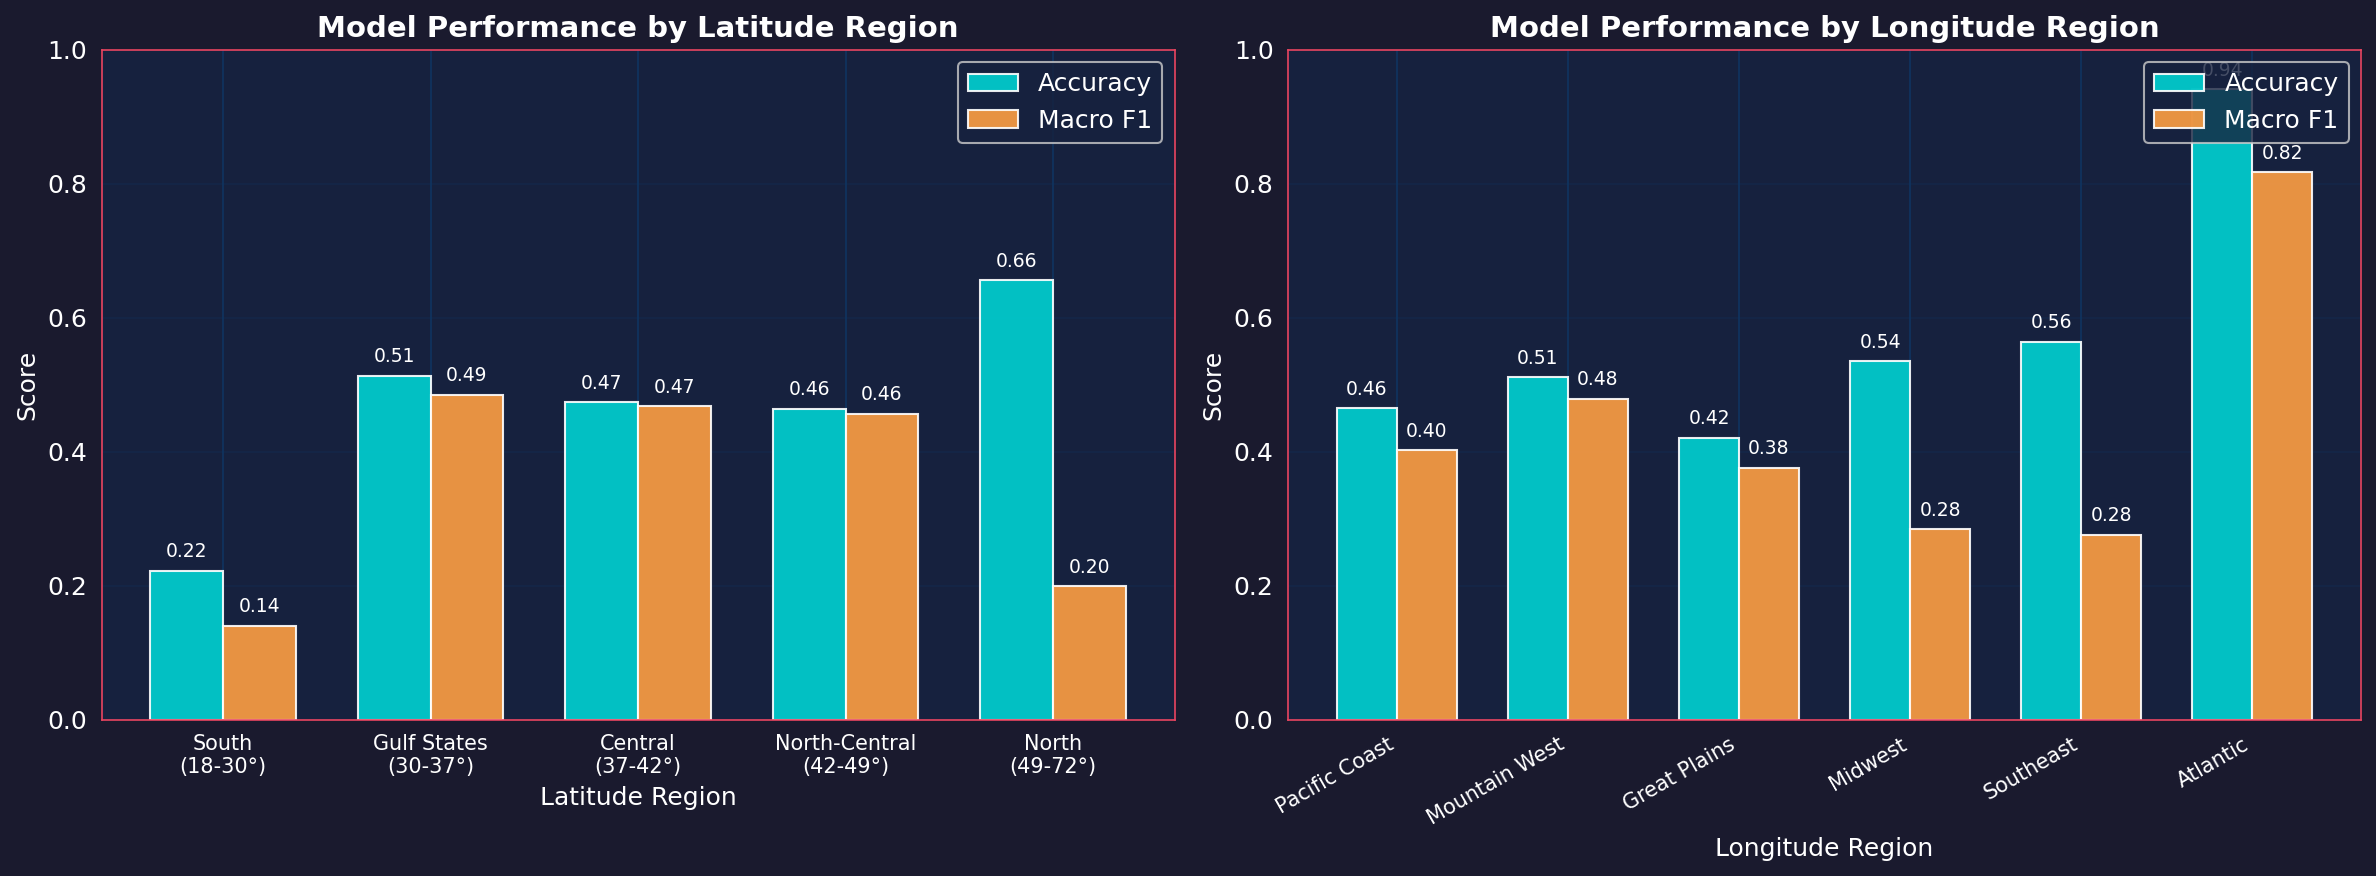

In [13]:
# Regional Performance Comparison - Side by Side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Latitude Regions
ax1 = axes[0]
if len(lat_results_test) > 0:
    x_lat = np.arange(len(lat_results_test))
    width = 0.35

    bars1 = ax1.bar(x_lat - width/2, lat_results_test['accuracy'], width, 
                    label='Accuracy', color='#00d2d3', alpha=0.9)
    bars2 = ax1.bar(x_lat + width/2, lat_results_test['macro_f1'], width,
                    label='Macro F1', color='#ff9f43', alpha=0.9)

    ax1.set_xlabel('Latitude Region')
    ax1.set_ylabel('Score')
    ax1.set_title('Model Performance by Latitude Region', fontsize=14, fontweight='bold')
    ax1.set_xticks(x_lat)
    ax1.set_xticklabels([s.replace(' (', '\n(') for s in lat_results_test['subgroup']], 
                        rotation=0, fontsize=10)
    ax1.legend(loc='upper right')
    ax1.set_ylim(0, 1)
    ax1.grid(axis='y', alpha=0.3)

    for bar in bars1:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{bar.get_height():.2f}', ha='center', fontsize=9, color='white')
    for bar in bars2:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{bar.get_height():.2f}', ha='center', fontsize=9, color='white')

# Longitude Regions
ax2 = axes[1]
if len(lon_results_test) > 0:
    x_lon = np.arange(len(lon_results_test))

    bars3 = ax2.bar(x_lon - width/2, lon_results_test['accuracy'], width,
                    label='Accuracy', color='#00d2d3', alpha=0.9)
    bars4 = ax2.bar(x_lon + width/2, lon_results_test['macro_f1'], width,
                    label='Macro F1', color='#ff9f43', alpha=0.9)

    ax2.set_xlabel('Longitude Region')
    ax2.set_ylabel('Score')
    ax2.set_title('Model Performance by Longitude Region', fontsize=14, fontweight='bold')
    ax2.set_xticks(x_lon)
    ax2.set_xticklabels(lon_results_test['subgroup'], rotation=30, ha='right', fontsize=10)
    ax2.legend(loc='upper right')
    ax2.set_ylim(0, 1)
    ax2.grid(axis='y', alpha=0.3)

    for bar in bars3:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{bar.get_height():.2f}', ha='center', fontsize=9, color='white')
    for bar in bars4:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{bar.get_height():.2f}', ha='center', fontsize=9, color='white')

plt.tight_layout()
plt.savefig('regional_performance_comparison.png', dpi=300, bbox_inches='tight',
            facecolor='#1a1a2e', edgecolor='none')
plt.show()

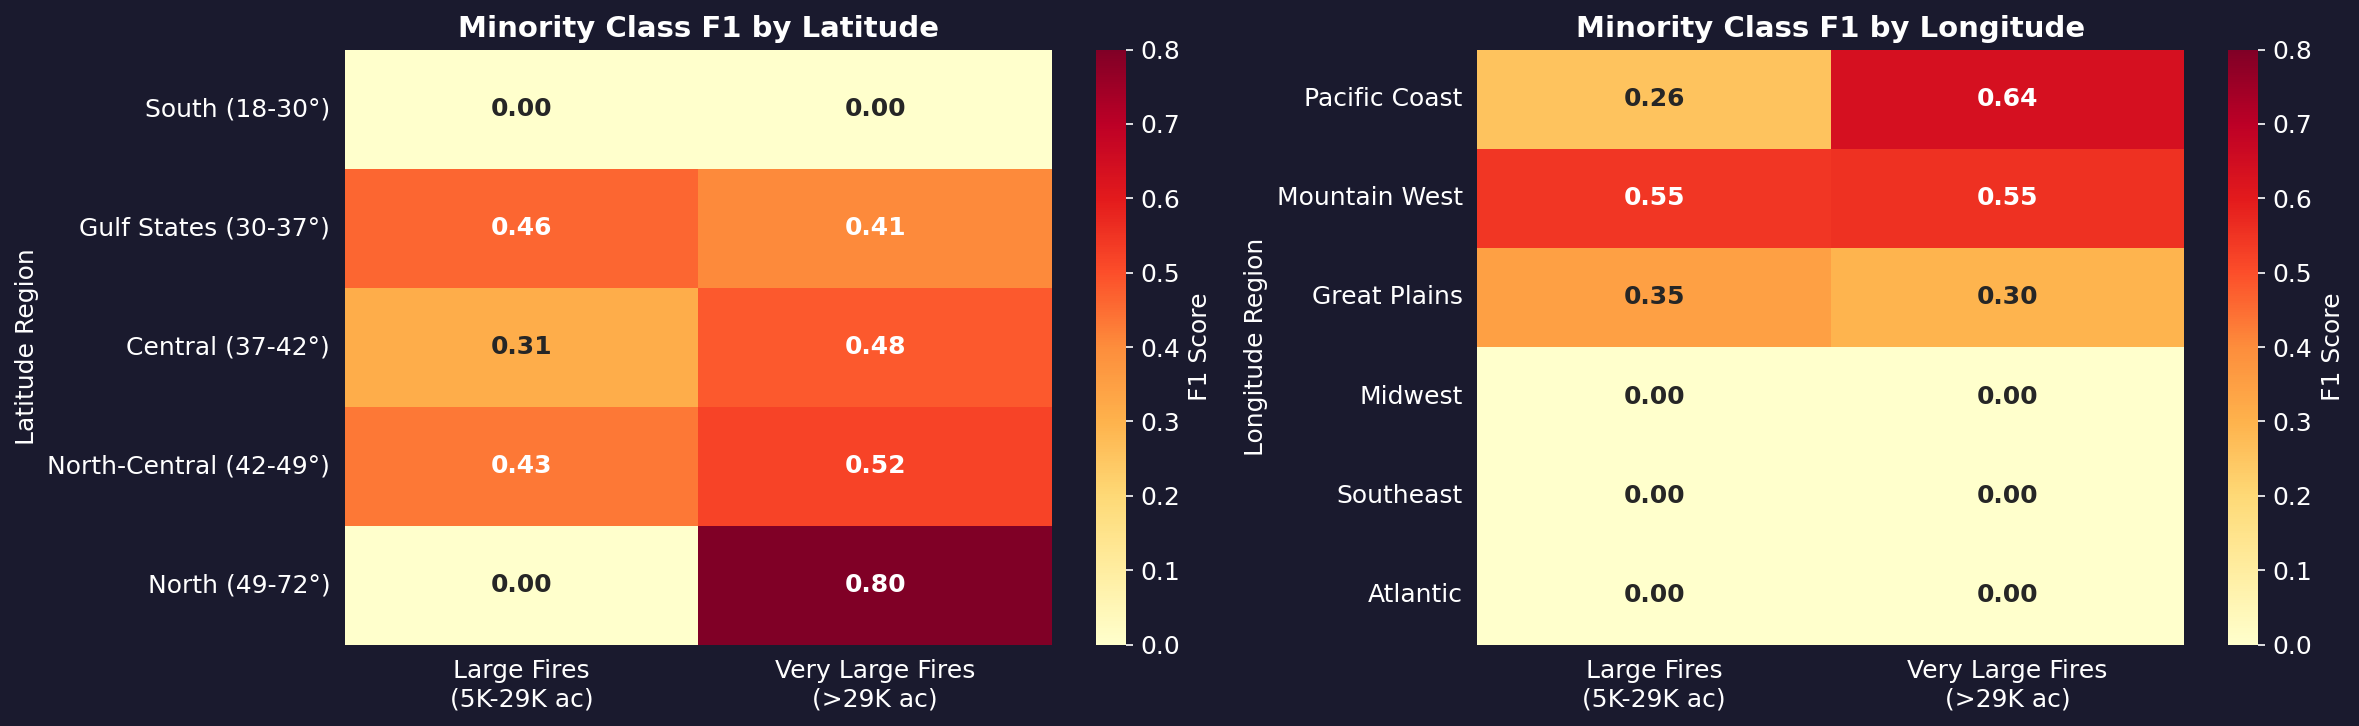

In [14]:
# Minority Class Performance Heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

if len(lat_results_test) > 0:
    lat_minority = lat_results_test[['subgroup', 'f1_large', 'f1_very large']].set_index('subgroup')
    lat_minority.columns = ['Large Fires\n(5K-29K ac)', 'Very Large Fires\n(>29K ac)']

    sns.heatmap(lat_minority, annot=True, fmt='.2f', cmap='YlOrRd', 
                ax=axes[0], vmin=0, vmax=0.8, cbar_kws={'label': 'F1 Score'},
                annot_kws={'fontsize': 12, 'fontweight': 'bold'})
    axes[0].set_title('Minority Class F1 by Latitude', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Latitude Region')
    axes[0].set_xlabel('')

if len(lon_results_test) > 0:
    lon_minority = lon_results_test[['subgroup', 'f1_large', 'f1_very large']].set_index('subgroup')
    lon_minority.columns = ['Large Fires\n(5K-29K ac)', 'Very Large Fires\n(>29K ac)']

    sns.heatmap(lon_minority, annot=True, fmt='.2f', cmap='YlOrRd',
                ax=axes[1], vmin=0, vmax=0.8, cbar_kws={'label': 'F1 Score'},
                annot_kws={'fontsize': 12, 'fontweight': 'bold'})
    axes[1].set_title('Minority Class F1 by Longitude', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Longitude Region')
    axes[1].set_xlabel('')

plt.tight_layout()
plt.savefig('minority_class_heatmap.png', dpi=300, bbox_inches='tight',
            facecolor='#1a1a2e', edgecolor='none')
plt.show()

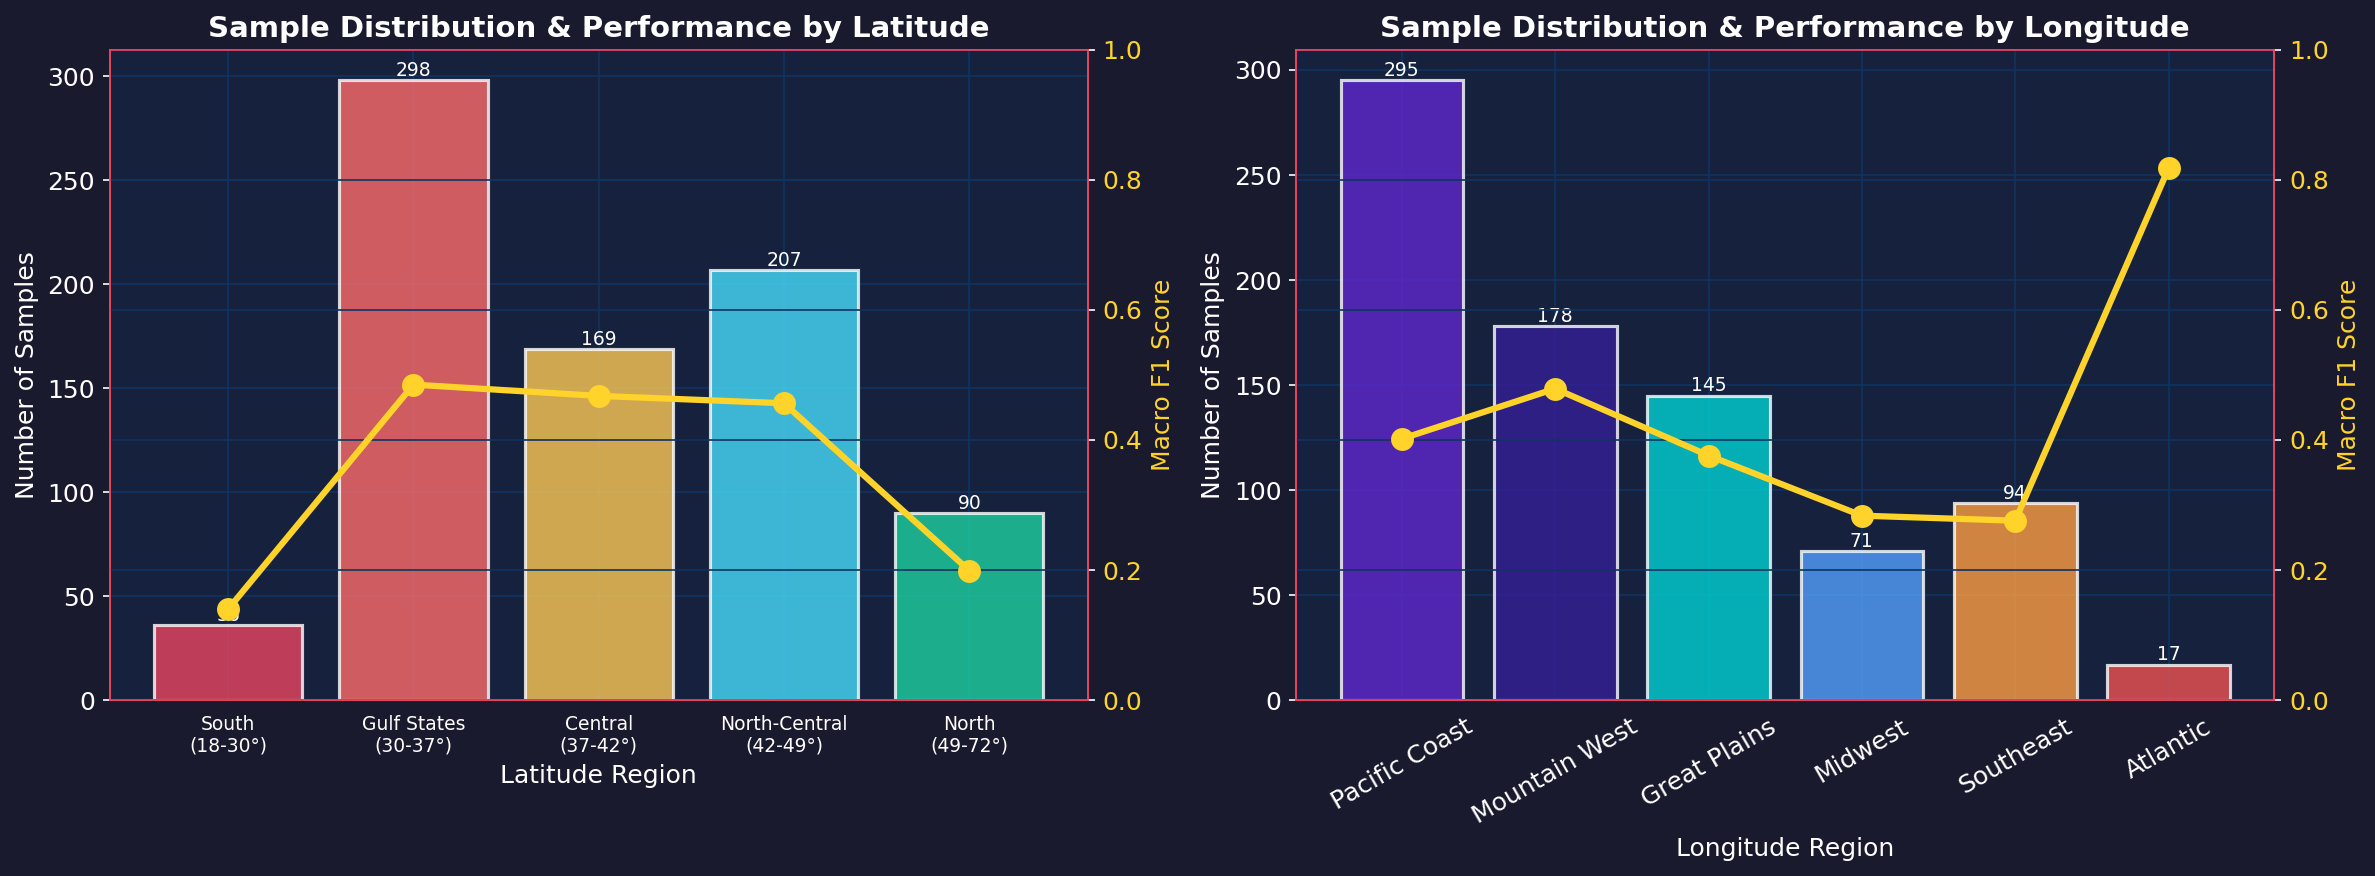

In [15]:
# Sample Distribution with Performance Overlay
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
if len(lat_results_test) > 0:
    colors_lat = REGION_COLORS['lat'][:len(lat_results_test)]
    bars = ax1.bar(lat_results_test['subgroup'], lat_results_test['n_samples'], 
                   color=colors_lat, alpha=0.8, edgecolor='white', linewidth=1.5)

    ax1.set_xlabel('Latitude Region')
    ax1.set_ylabel('Number of Samples', color='white')
    ax1.set_title('Sample Distribution & Performance by Latitude', fontsize=14, fontweight='bold')
    ax1.set_xticklabels([s.replace(' (', '\n(') for s in lat_results_test['subgroup']], 
                        rotation=0, ha='center', fontsize=9)

    ax1_twin = ax1.twinx()
    ax1_twin.plot(lat_results_test['subgroup'], lat_results_test['macro_f1'], 
                  'o-', color='#ffd32a', linewidth=3, markersize=10, label='Macro F1')
    ax1_twin.set_ylabel('Macro F1 Score', color='#ffd32a')
    ax1_twin.tick_params(axis='y', labelcolor='#ffd32a')
    ax1_twin.set_ylim(0, 1)

    for bar in bars:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                 f'{int(bar.get_height()):,}', ha='center', fontsize=9, color='white')

ax2 = axes[1]
if len(lon_results_test) > 0:
    colors_lon = REGION_COLORS['lon'][:len(lon_results_test)]
    bars2 = ax2.bar(lon_results_test['subgroup'], lon_results_test['n_samples'],
                    color=colors_lon, alpha=0.8, edgecolor='white', linewidth=1.5)

    ax2.set_xlabel('Longitude Region')
    ax2.set_ylabel('Number of Samples', color='white')
    ax2.set_title('Sample Distribution & Performance by Longitude', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='x', rotation=30)

    ax2_twin = ax2.twinx()
    ax2_twin.plot(lon_results_test['subgroup'], lon_results_test['macro_f1'],
                  'o-', color='#ffd32a', linewidth=3, markersize=10, label='Macro F1')
    ax2_twin.set_ylabel('Macro F1 Score', color='#ffd32a')
    ax2_twin.tick_params(axis='y', labelcolor='#ffd32a')
    ax2_twin.set_ylim(0, 1)

    for bar in bars2:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                 f'{int(bar.get_height()):,}', ha='center', fontsize=9, color='white')

plt.tight_layout()
plt.savefig('sample_distribution_performance.png', dpi=300, bbox_inches='tight',
            facecolor='#1a1a2e', edgecolor='none')
plt.show()

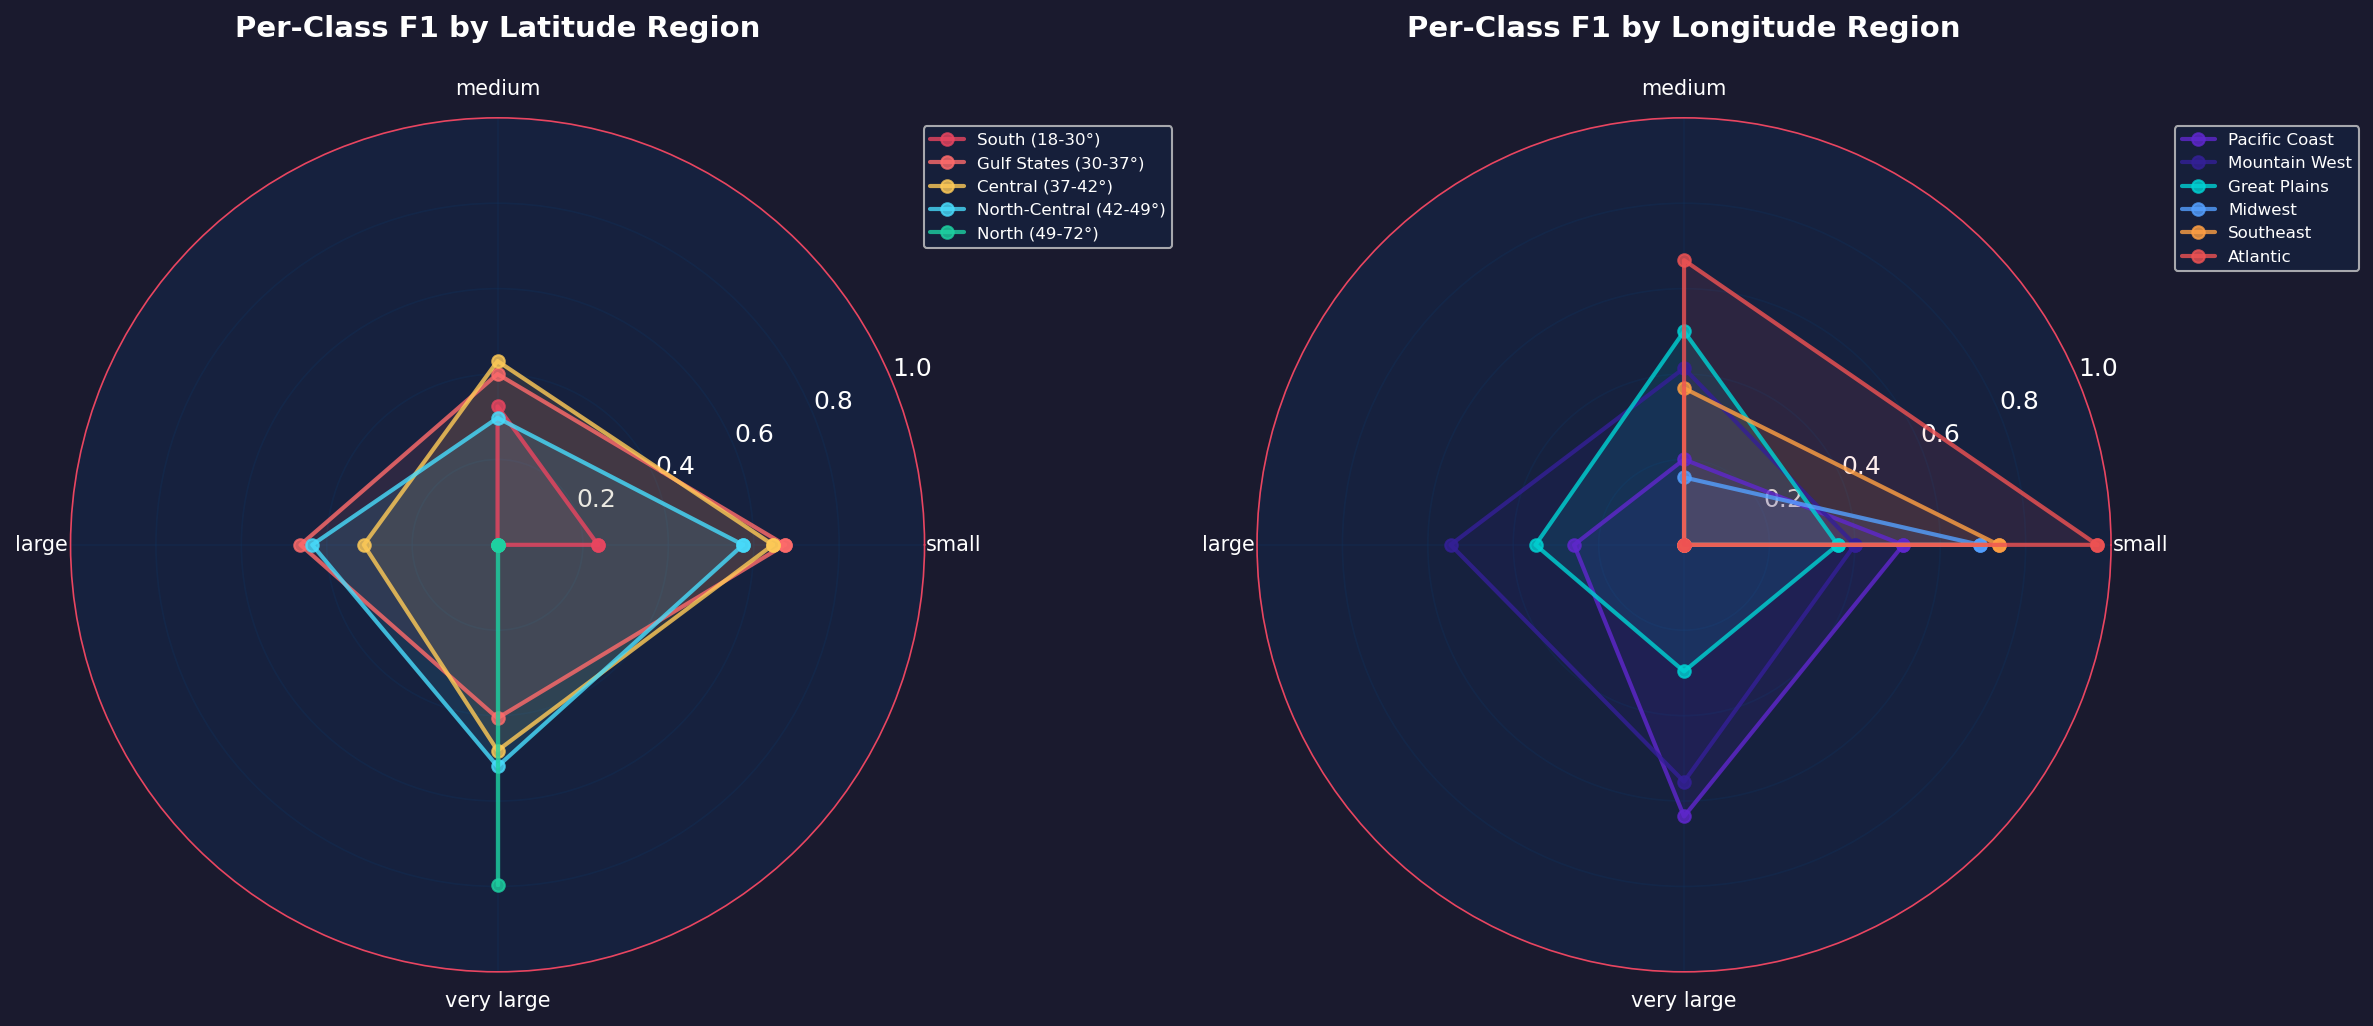

In [16]:
# Radar Chart - Per-Class Performance by Region
from math import pi

def create_radar_chart(data, title, colors, ax):
    """Create a radar chart for regional performance."""
    categories = CLASS_NAMES
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    for i, (idx, row) in enumerate(data.iterrows()):
        values = [row.get(f'f1_{c}', 0) for c in CLASS_NAMES]
        values += values[:1]

        ax.plot(angles, values, 'o-', linewidth=2, label=row['subgroup'],
                color=colors[i % len(colors)], alpha=0.8)
        ax.fill(angles, values, color=colors[i % len(colors)], alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=8)
    ax.grid(True, alpha=0.3)

fig, axes = plt.subplots(1, 2, figsize=(16, 7), subplot_kw=dict(polar=True))

if len(lat_results_test) > 0:
    create_radar_chart(lat_results_test, 'Per-Class F1 by Latitude Region',
                       REGION_COLORS['lat'], axes[0])

if len(lon_results_test) > 0:
    create_radar_chart(lon_results_test, 'Per-Class F1 by Longitude Region',
                       REGION_COLORS['lon'], axes[1])

plt.tight_layout()
plt.savefig('radar_regional_performance.png', dpi=300, bbox_inches='tight',
            facecolor='#1a1a2e', edgecolor='none')
plt.show()

## Step 7: Comprehensive Summary Dashboard

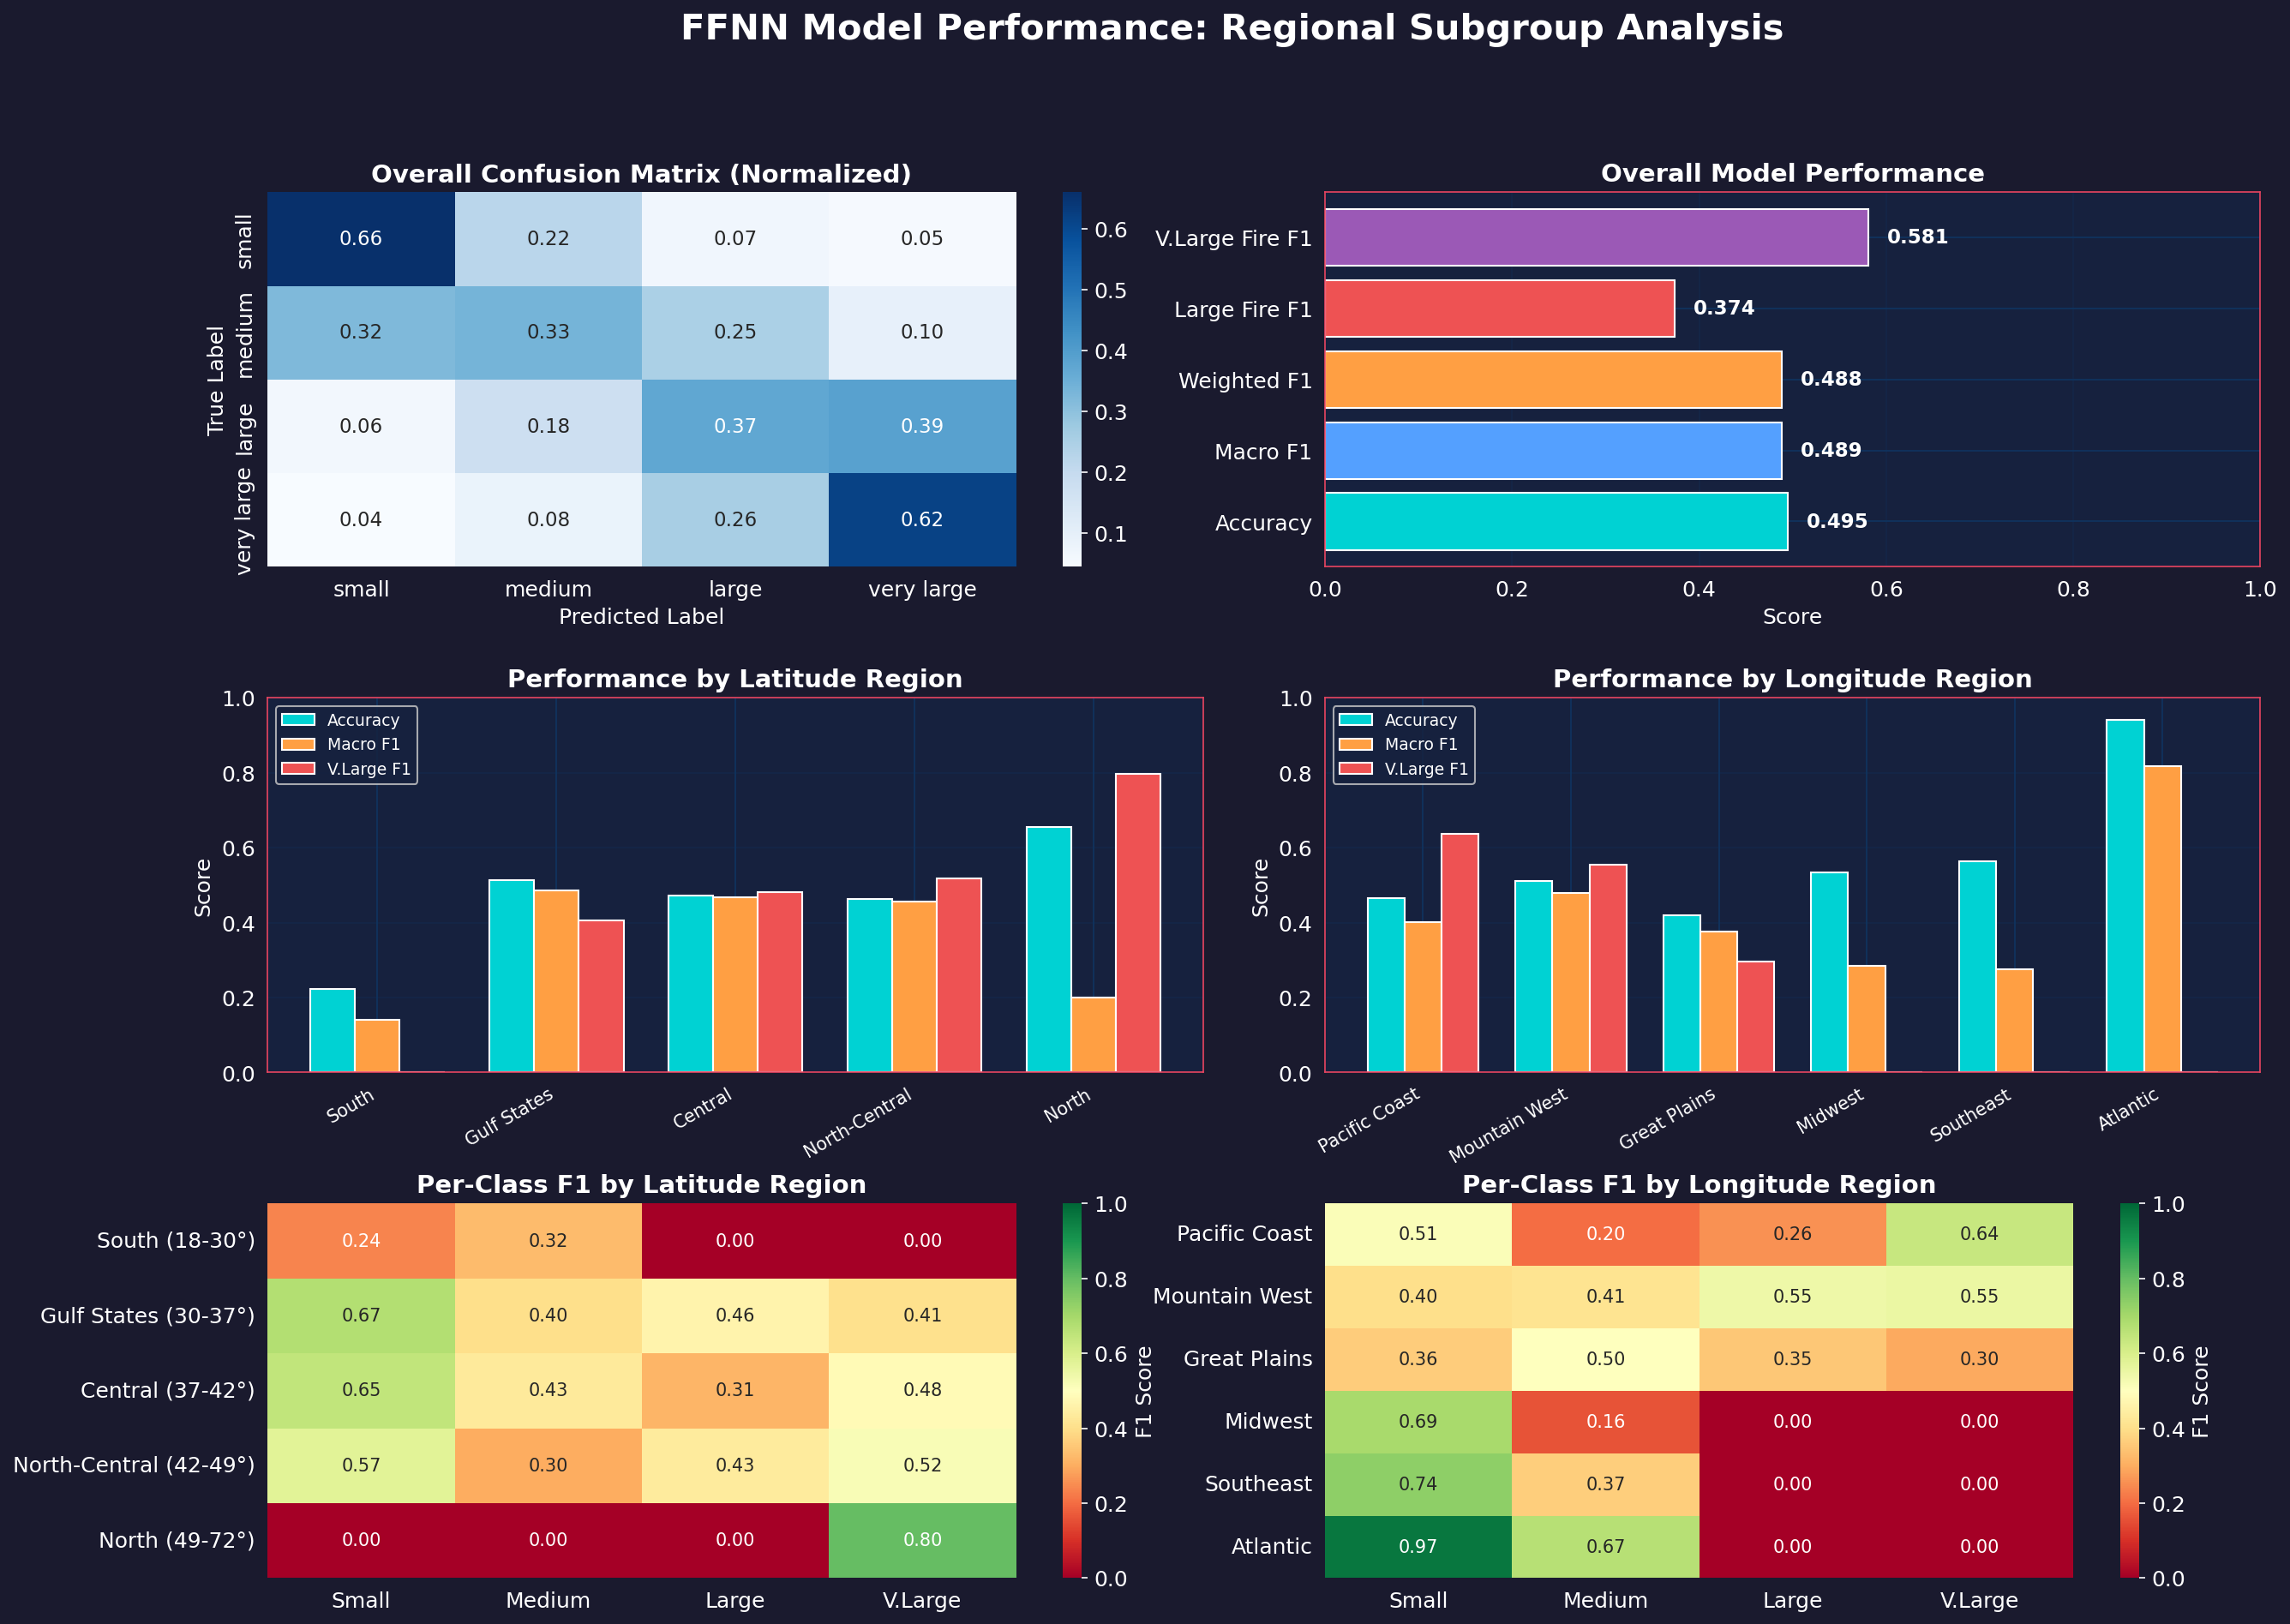

In [17]:
# Create a comprehensive dashboard figure
fig = plt.figure(figsize=(20, 14))
gs = GridSpec(3, 4, figure=fig, hspace=0.35, wspace=0.3)

fig.suptitle('FFNN Model Performance: Regional Subgroup Analysis',
             fontsize=20, fontweight='bold', y=0.98)

# 1. Overall Confusion Matrix
ax1 = fig.add_subplot(gs[0, 0:2])
cm = confusion_matrix(y_test, y_pred_test)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax1,
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            annot_kws={'fontsize': 11})
ax1.set_title('Overall Confusion Matrix (Normalized)', fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# 2. Overall Metrics
ax2 = fig.add_subplot(gs[0, 2:4])
per_class_f1 = f1_score(y_test, y_pred_test, average=None, labels=[0,1,2,3])
metrics_overall = pd.DataFrame({
    'Metric': ['Accuracy', 'Macro F1', 'Weighted F1', 'Large Fire F1', 'V.Large Fire F1'],
    'Score': [
        accuracy_score(y_test, y_pred_test),
        f1_score(y_test, y_pred_test, average='macro'),
        f1_score(y_test, y_pred_test, average='weighted'),
        per_class_f1[2],
        per_class_f1[3]
    ]
})
colors_metrics = ['#00d2d3', '#54a0ff', '#ff9f43', '#ee5253', '#9b59b6']
bars = ax2.barh(metrics_overall['Metric'], metrics_overall['Score'], color=colors_metrics)
ax2.set_xlim(0, 1)
ax2.set_title('Overall Model Performance', fontweight='bold')
ax2.set_xlabel('Score')
for bar, val in zip(bars, metrics_overall['Score']):
    ax2.text(val + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.3f}',
             va='center', fontsize=11, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. Latitude Performance
ax3 = fig.add_subplot(gs[1, 0:2])
if len(lat_results_test) > 0:
    x = np.arange(len(lat_results_test))
    width = 0.25
    ax3.bar(x - width, lat_results_test['accuracy'], width, label='Accuracy', color='#00d2d3')
    ax3.bar(x, lat_results_test['macro_f1'], width, label='Macro F1', color='#ff9f43')
    ax3.bar(x + width, lat_results_test['f1_very large'], width, label='V.Large F1', color='#ee5253')
    ax3.set_xticks(x)
    ax3.set_xticklabels([s.split(' (')[0] for s in lat_results_test['subgroup']],
                        rotation=30, ha='right', fontsize=10)
    ax3.set_ylabel('Score')
    ax3.set_ylim(0, 1)
    ax3.set_title('Performance by Latitude Region', fontweight='bold')
    ax3.legend(loc='upper left', fontsize=9)
    ax3.grid(axis='y', alpha=0.3)

# 4. Longitude Performance
ax4 = fig.add_subplot(gs[1, 2:4])
if len(lon_results_test) > 0:
    x = np.arange(len(lon_results_test))
    ax4.bar(x - width, lon_results_test['accuracy'], width, label='Accuracy', color='#00d2d3')
    ax4.bar(x, lon_results_test['macro_f1'], width, label='Macro F1', color='#ff9f43')
    ax4.bar(x + width, lon_results_test['f1_very large'], width, label='V.Large F1', color='#ee5253')
    ax4.set_xticks(x)
    ax4.set_xticklabels(lon_results_test['subgroup'], rotation=30, ha='right', fontsize=10)
    ax4.set_ylabel('Score')
    ax4.set_ylim(0, 1)
    ax4.set_title('Performance by Longitude Region', fontweight='bold')
    ax4.legend(loc='upper left', fontsize=9)
    ax4.grid(axis='y', alpha=0.3)

# 5. Per-Class Heatmaps
ax5 = fig.add_subplot(gs[2, 0:2])
if len(lat_results_test) > 0:
    lat_heatmap = lat_results_test.set_index('subgroup')[['f1_small', 'f1_medium', 'f1_large', 'f1_very large']]
    lat_heatmap.columns = ['Small', 'Medium', 'Large', 'V.Large']
    sns.heatmap(lat_heatmap, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax5,
                vmin=0, vmax=1, cbar_kws={'label': 'F1 Score'}, annot_kws={'fontsize': 10})
    ax5.set_title('Per-Class F1 by Latitude Region', fontweight='bold')
    ax5.set_ylabel('')

ax6 = fig.add_subplot(gs[2, 2:4])
if len(lon_results_test) > 0:
    lon_heatmap = lon_results_test.set_index('subgroup')[['f1_small', 'f1_medium', 'f1_large', 'f1_very large']]
    lon_heatmap.columns = ['Small', 'Medium', 'Large', 'V.Large']
    sns.heatmap(lon_heatmap, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax6,
                vmin=0, vmax=1, cbar_kws={'label': 'F1 Score'}, annot_kws={'fontsize': 10})
    ax6.set_title('Per-Class F1 by Longitude Region', fontweight='bold')
    ax6.set_ylabel('')

plt.savefig('comprehensive_regional_dashboard.png', dpi=300, bbox_inches='tight',
            facecolor='#1a1a2e', edgecolor='none')
plt.show()

### Add Socioeconomic Variables

In [18]:
import pathlib
import os

# Load ONLY cols from CSV to avoid loading full dataset
notebook_dir = pathlib.Path(os.getcwd())
csv_path = notebook_dir.parent / "data" / "external" / "FPA_FOD_Plus.csv"

# Read only the to-be-joined columns + socioeconomic variables
usecols = ['LATITUDE', 'LONGITUDE', 'FIRE_YEAR', 'DISCOVERY_DOY',
           'FPL200S', 'M_PLN', 'M_TRN', 'TPF']

print("Loading socioeconomic columns (memory-efficient)...")
df_socio_raw = pd.read_csv(csv_path, usecols=usecols, low_memory=False)

# Composite join unique key (LATITUDE + LONGITUDE + FIRE_YEAR + DOY)
def create_join_key(df):
    return (
        df['LATITUDE'].round(4).astype(str) + '_' +
        df['LONGITUDE'].round(4).astype(str) + '_' +
        df['FIRE_YEAR'].astype(str) + '_' +
        df['DISCOVERY_DOY'].astype(str)
    )

df_socio_raw['_join_key'] = create_join_key(df_socio_raw)
df_test_proc['_join_key'] = create_join_key(df_test_proc)

# Merge and keep only first
df_socio_raw_dedup = df_socio_raw.drop_duplicates(subset='_join_key', keep='first')
test_socio = df_test_proc[['_join_key']].merge(
    df_socio_raw_dedup[['_join_key', 'FPL200S', 'M_PLN', 'M_TRN', 'TPF']],
    on='_join_key',
    how='left'
)

# Free up memory to avoid the OOM issues I had before
del df_socio_raw, df_socio_raw_dedup
gc.collect()

print(f"\nMerge success eval: {test_socio['FPL200S'].notna().sum()}/{len(test_socio)}")

# Extract socioeconomic variables for test set
fpl_test = test_socio['FPL200S']
pln_test = test_socio['M_PLN']
trn_test = test_socio['M_TRN']
tpf_test = test_socio['TPF']

Loading socioeconomic columns (memory-efficient)...

Merge success eval: 777/800


In [19]:
# Create Socioeconomic Subgroup Labels

# Income Status (FPL200S): Binary - whether county has >20% below 200% poverty line
def assign_income_status(val):
    if pd.isna(val):
        return 'Unknown'
    return 'Low-Income County' if val == 1 else 'Standard County'

income_status_test = fpl_test.apply(assign_income_status)
print("Income Status Distribution:")
print(income_status_test.value_counts())

# Pollution Factor (M_PLN): Binary - disadvantaged community flag
def assign_pollution_status(val):
    if pd.isna(val):
        return 'Unknown'
    return 'High Pollution Burden' if val == 1 else 'Standard'

pollution_status_test = pln_test.apply(assign_pollution_status)

# Transportation Factor (M_TRN): Binary - disadvantaged community flag
def assign_transport_status(val):
    if pd.isna(val):
        return 'Unknown'
    return 'Transportation Disadvantaged' if val == 1 else 'Standard'

transport_status_test = trn_test.apply(assign_transport_status)

# Total Population (TPF): Quartiles
tpf_valid = tpf_test.dropna()
if len(tpf_valid) > 0:
    quartile_labels = ['Q1 (Low Pop)', 'Q2 (Med-Low)', 'Q3 (Med-High)', 'Q4 (High Pop)']
    tpf_quartiles = pd.qcut(tpf_valid, q=4, labels=quartile_labels, duplicates='drop')

    population_test = pd.Series('Unknown', index=tpf_test.index)
    population_test.loc[tpf_valid.index] = tpf_quartiles
else:
    population_test = pd.Series('Unknown', index=tpf_test.index)

Income Status Distribution:
FPL200S
Standard County      435
Low-Income County    342
Unknown               23
Name: count, dtype: int64


In [20]:
# Income Status
income_order = ['Low-Income County', 'Standard County']
income_results = run_subgroup_analysis(income_status_test, y_test, y_pred_test, income_order)

# Pollution Factor
pollution_order = ['High Pollution Burden', 'Standard']
pollution_results = run_subgroup_analysis(pollution_status_test, y_test, y_pred_test, pollution_order)

# Population Quartiles
pop_order = ['Q1 (Low Pop)', 'Q2 (Med-Low)', 'Q3 (Med-High)', 'Q4 (High Pop)']
population_results = run_subgroup_analysis(population_test, y_test, y_pred_test, pop_order)

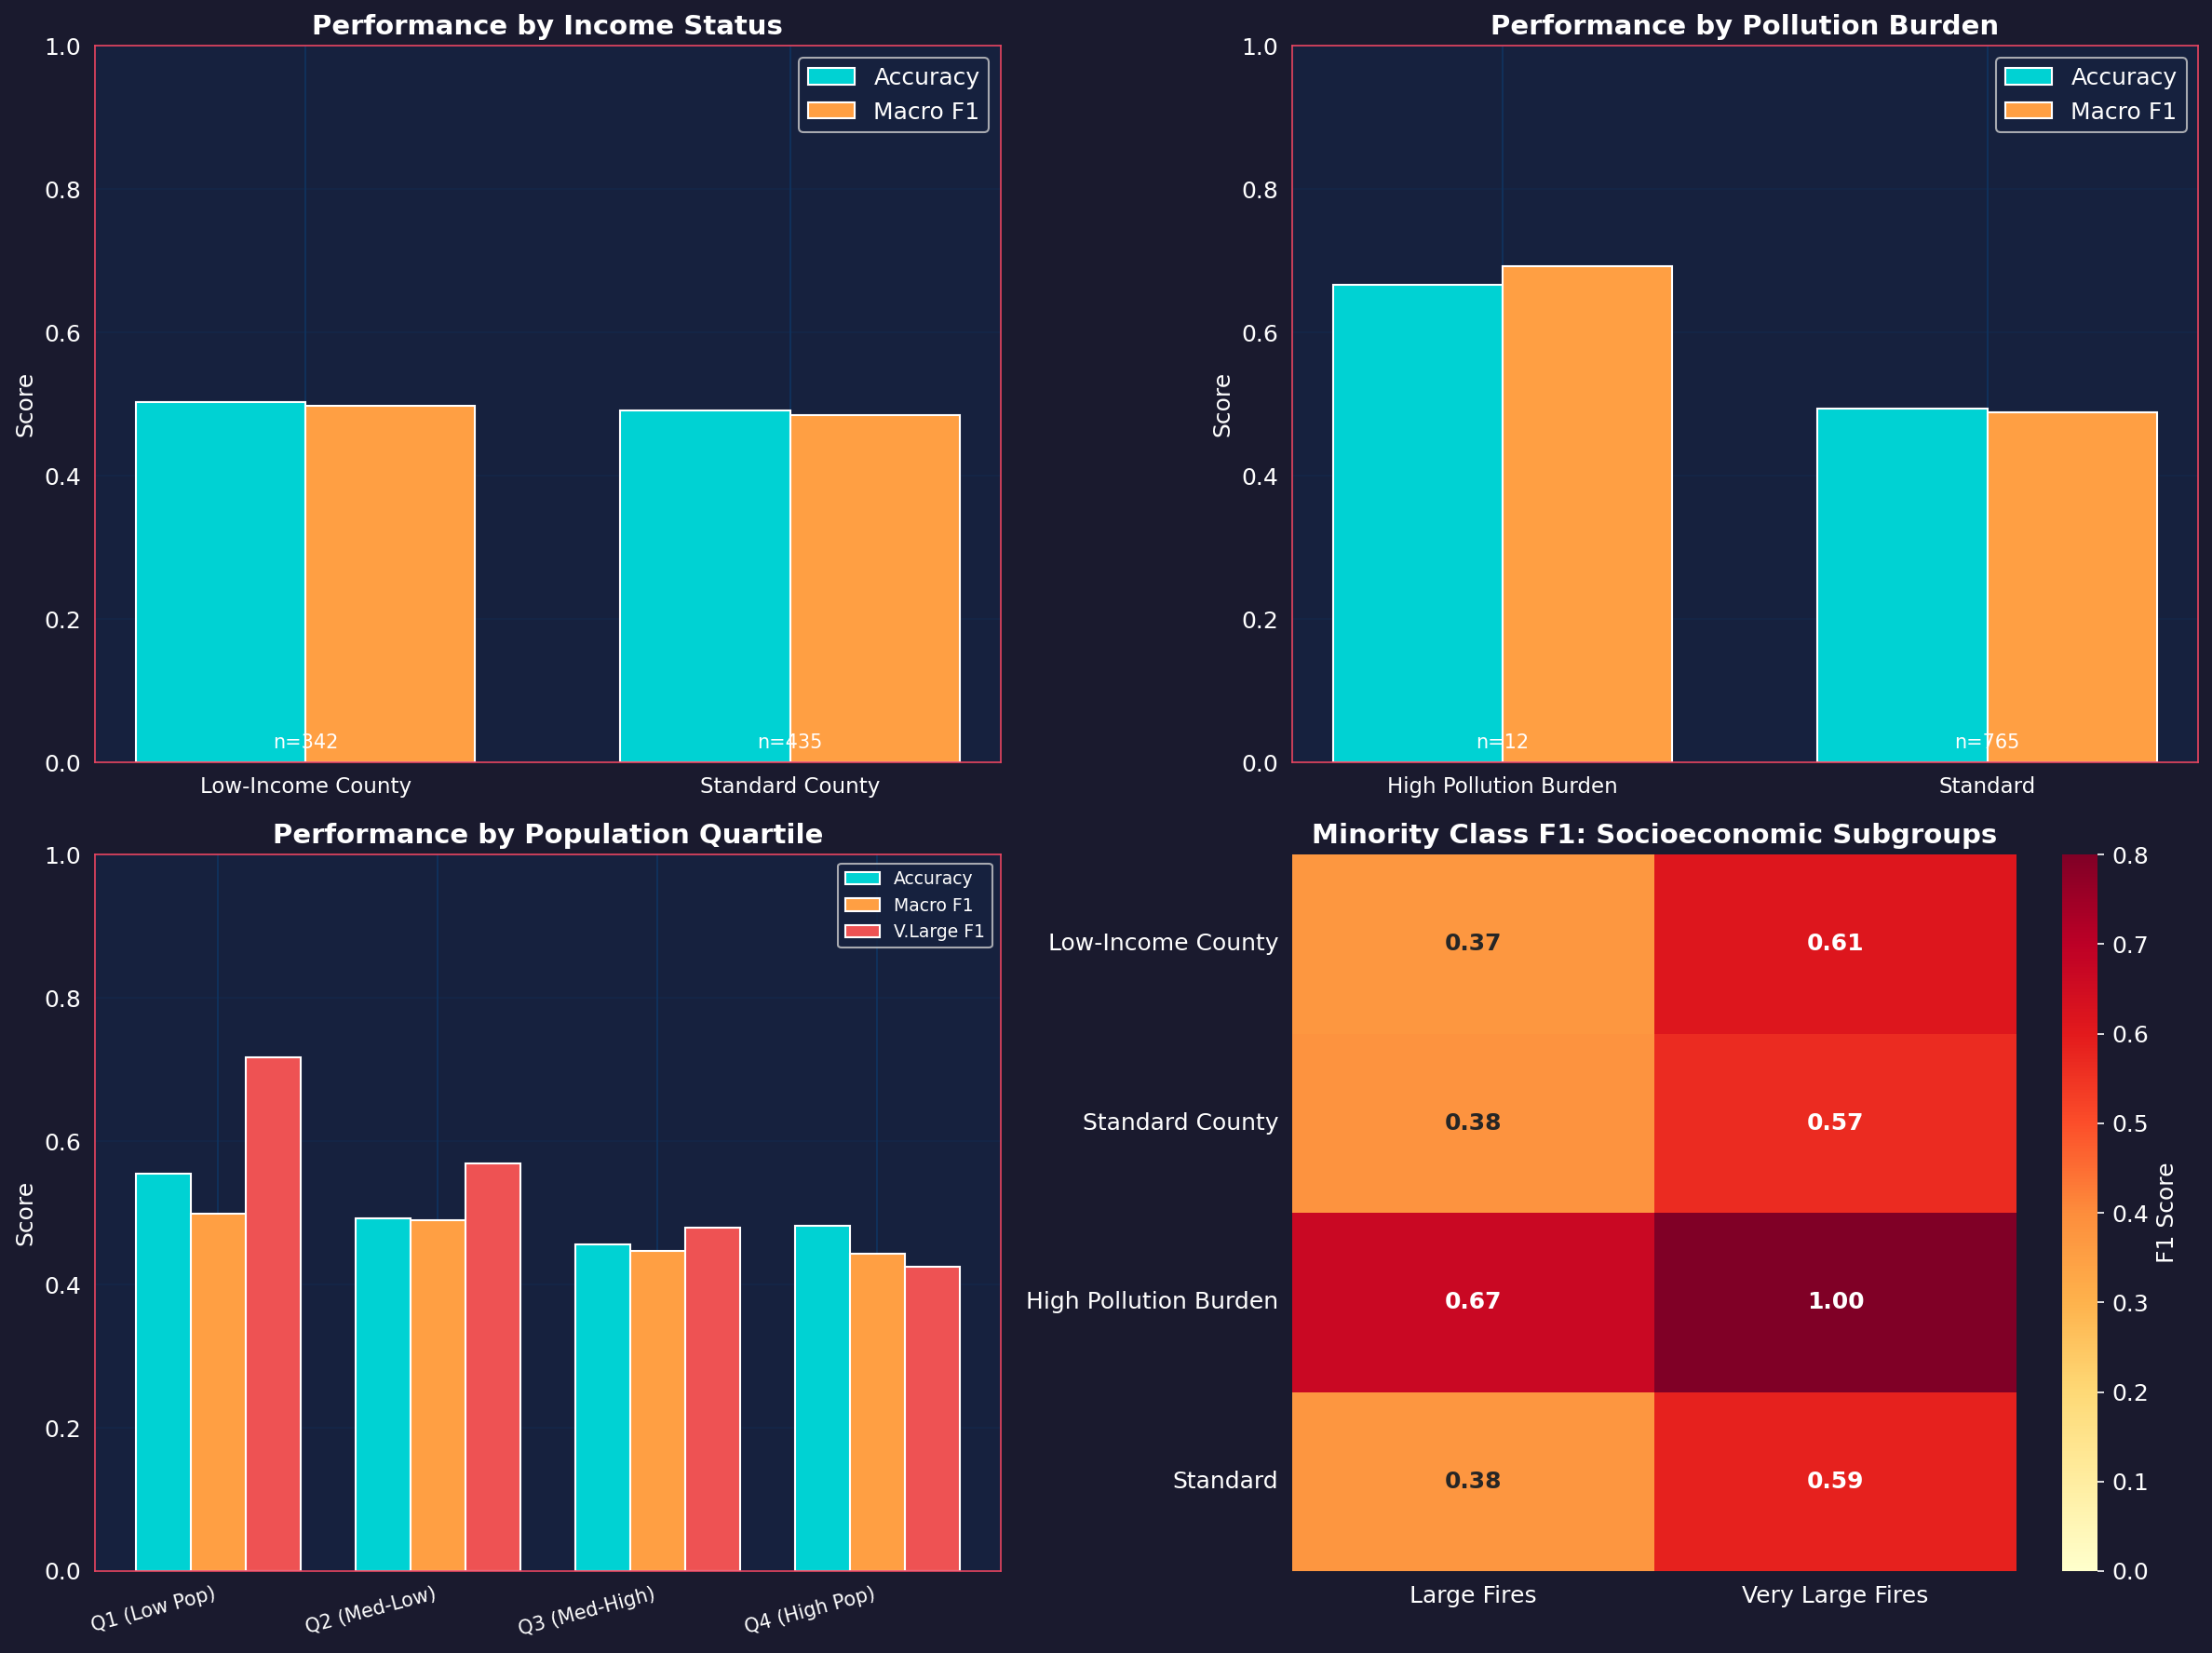

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Income Status
ax1 = axes[0, 0]
if len(income_results) > 0:
    x = np.arange(len(income_results))
    width = 0.35
    ax1.bar(x - width/2, income_results['accuracy'], width, label='Accuracy', color='#00d2d3')
    ax1.bar(x + width/2, income_results['macro_f1'], width, label='Macro F1', color='#ff9f43')
    ax1.set_xticks(x)
    ax1.set_xticklabels(income_results['subgroup'], fontsize=11)
    ax1.set_ylabel('Score')
    ax1.set_ylim(0, 1)
    ax1.set_title('Performance by Income Status', fontweight='bold', fontsize=14)
    ax1.legend(loc='upper right')
    ax1.grid(axis='y', alpha=0.3)
    # Add sample counts
    for i, n in enumerate(income_results['n_samples']):
        ax1.annotate(f'n={n:,}', xy=(i, 0.02), ha='center', fontsize=10, color='white')

# Pollution Factor
ax2 = axes[0, 1]
if len(pollution_results) > 0:
    x = np.arange(len(pollution_results))
    ax2.bar(x - width/2, pollution_results['accuracy'], width, label='Accuracy', color='#00d2d3')
    ax2.bar(x + width/2, pollution_results['macro_f1'], width, label='Macro F1', color='#ff9f43')
    ax2.set_xticks(x)
    ax2.set_xticklabels(pollution_results['subgroup'], fontsize=11)
    ax2.set_ylabel('Score')
    ax2.set_ylim(0, 1)
    ax2.set_title('Performance by Pollution Burden', fontweight='bold', fontsize=14)
    ax2.legend(loc='upper right')
    ax2.grid(axis='y', alpha=0.3)
    for i, n in enumerate(pollution_results['n_samples']):
        ax2.annotate(f'n={n:,}', xy=(i, 0.02), ha='center', fontsize=10, color='white')

# Population Quartiles
ax3 = axes[1, 0]
if len(population_results) > 0:
    x = np.arange(len(population_results))
    width = 0.25
    ax3.bar(x - width, population_results['accuracy'], width, label='Accuracy', color='#00d2d3')
    ax3.bar(x, population_results['macro_f1'], width, label='Macro F1', color='#ff9f43')
    ax3.bar(x + width, population_results['f1_very large'], width, label='V.Large F1', color='#ee5253')
    ax3.set_xticks(x)
    ax3.set_xticklabels(population_results['subgroup'], rotation=15, ha='right', fontsize=10)
    ax3.set_ylabel('Score')
    ax3.set_ylim(0, 1)
    ax3.set_title('Performance by Population Quartile', fontweight='bold', fontsize=14)
    ax3.legend(loc='upper right', fontsize=9)
    ax3.grid(axis='y', alpha=0.3)

# Minority Class Heatmap for Socioeconomic Groups
ax4 = axes[1, 1]
# Combine income and pollution for heatmap
socio_combined = pd.concat([
    income_results[['subgroup', 'f1_large', 'f1_very large']],
    pollution_results[['subgroup', 'f1_large', 'f1_very large']]
], ignore_index=True)

if len(socio_combined) > 0:
    socio_heatmap = socio_combined.set_index('subgroup')
    socio_heatmap.columns = ['Large Fires', 'Very Large Fires']
    sns.heatmap(socio_heatmap, annot=True, fmt='.2f', cmap='YlOrRd',
                ax=ax4, vmin=0, vmax=0.8, cbar_kws={'label': 'F1 Score'},
                annot_kws={'fontsize': 12, 'fontweight': 'bold'})
    ax4.set_title('Minority Class F1: Socioeconomic Subgroups', fontweight='bold', fontsize=14)
    ax4.set_ylabel('')

plt.tight_layout()
plt.savefig('socioeconomic_subgroup_analysis.png', dpi=300, bbox_inches='tight',
            facecolor='#1a1a2e', edgecolor='none')
plt.show()